In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
model_path = './Models/'

## Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
# model.save(model_path + "my_model.keras")

## It can be used to reconstruct the model identically.
# reconstructed_model = keras.models.load_model("my_model.keras")

- conda create --name ML4 python=3.12
    - conda activate ML4
    - conda deactivate
    - conda install -n ML4 keras
    - conda install -n ML4 tensorflow

    - conda install -n ML4 pandas ipykernel matplotlib seaborn
    - conda install --name ML4 pydot
    - conda install --name ML4 plotly

    - conda install anaconda::keras,
    - conda install pandas ipykernel matplotlib seaborn tensorflow scikit-learn
        - use python 3.12 for conpatibility


-  conda create --name KerasTensorFlow --clone ML4

**Resources** :

*Matrix Factorization techniques for Recommender Systems*, Koren (2009)    
https://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/Koren_Matrix_Factorization.pdf

Hands on Machine Learning with scikit-learn and tensorflow:             
https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing

The movieLens dataset:                                                
https://grouplens.org/datasets/movielens/ 

Keras Functional API doc :                                            
https://keras.io/guides/functional_api/


# Recommender systems : collaborative filtering via matrix factorization

Do you wonder how Netflix is able to recommend you movies despite it doesn't know anything about you but the ratings you gave to the movies you watched ? This is what we are going to explore during this 3 days machine learning module.

First off, let's learn about what are recommender system, collaborative filtering and matrix factorization techniques, which are all very well introduced in Koren's 2009 famous article : *Matrix Factorization techniques for Recommender Systems* : https://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/Koren_Matrix_Factorization.pdf . Read the 4 first pages (up to section *adding biases* included). 

Through this notebook we are going to re-implement the model described in the pages you read, and apply it to a classic movie ratings dataset coming from the website *movieLens*. To do so, we will use a powerful deep learning python library called *Keras*, that makes it easy to train complex models based on linear algebra.

My resume of the *Matrix Factorization techniques for Recommender Systems* : https://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/Koren_Matrix_Factorization.pdf 

Recomendation strategie:
- content filtering
- collaborative filtering
       - neighborhood methods <br> exemple user oriented neighborhood methods
       - latent factor models
           - based on matrix
    
Leearning algo
    - Stochastic gradient descent 
    http://sifter.org/~simon/journal/20061211.html
    - Alternating least squares (ALS)
    
ADDING BIASES
    
ADDITIONAL INPUT SOURCES
    
TEMPORAL DYNAMICS
    
INPUTS WITH VARYING CONFIDENCE LEVELS
    
NETFLIX PRIZE COMPETITION

My notes:
- https://grouplens.org/datasets/movielens/latest/
- https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset


## Load the dataset

For this module, we are going to use the movieLens dataset, that contains data from the movie recommending website movielens. The data is a subset of ratings from 0 to 5 given by some users of the website to a subset of movies. You can read more about it here (we are using the latest small dataset) : https://grouplens.org/datasets/movielens/ , and in the *README* file that is in the *data/ml-latest-small/* folder.

Load the ratings data from the `ratings.csv` file into a dataframe. The userId and movieId provided in the file don't start from 0, and are not contiguous (i.e. there are missing indexes).

Re-index the user and movie ids to indexes going from 0 to `nb_users` and 0 to `nb_movies` respectively, by building two dictionnaries `user_ids_map` and `movie_ids_map` that maps the file ids to your new ids. 
And finally, split the rows of this dataframe in a random 90%/10% train/test sets.

To do so, fill the `get_train_test_sets` function below, and respect the returned objects structures that are described in the docstring.


In [3]:
ml_latest_small_path= 'data/ml-latest-small/'#'./data/ml-latest-small/'

ratings_s_path =  ml_latest_small_path+'ratings.csv'
data= pd.read_csv(ratings_s_path, delimiter=',') # userId,movieId,rating,timestamp
# display (ratings.describe())
# display (ratings.userId.unique().tolist())
# users=ratings.userId.unique().tolist()#.reset_index()

user_ids_map = {value : index  for index, value in enumerate(data.userId.unique().tolist())}
movie_ids_map = {int(value) : index  for index, value in enumerate(data.movieId.unique())}
display (len(user_ids_map), data.userId.nunique())
display (len(movie_ids_map), data.movieId.nunique())

# display(movie_ids_map)

# display(user_ids_map)
# ratings['newUserId']=
# ratings.apply(lambda x : user_ids_map[x.loc['userId']])

# avec apply
#ratings["newUserId"]=ratings.apply(lambda x : user_ids_map[x.userId], axis=1)

# avec maper insert
data.insert(1, "newUserId", data.apply(lambda x : user_ids_map[x.userId], axis=1))


train= data.sample(frac=0.9, axis=0)
test= data.drop(train.index)
display (data)
display(train)
display(test)

610

610

9724

9724

,userId,newUserId,movieId,rating,timestamp
0,1,0,1,4.0,964982703
1,1,0,3,4.0,964981247
2,1,0,6,4.0,964982224
3,1,0,47,5.0,964983815
4,1,0,50,5.0,964982931
...,...,...,...,...,...
100831,610,609,166534,4.0,1493848402
100832,610,609,168248,5.0,1493850091
100833,610,609,168250,5.0,1494273047
100834,610,609,168252,5.0,1493846352


,userId,newUserId,movieId,rating,timestamp
25535,177,176,45447,3.5,1435526171
78857,489,488,4235,4.0,1332706148
83707,534,533,4011,4.0,1459787998
36277,247,246,54286,3.5,1467644268
9479,64,63,365,4.0,1161566490
...,...,...,...,...,...
65327,419,418,1097,0.5,1321659113
4213,28,27,290,3.0,1234570350
4802,29,28,2028,5.0,1362016835
49973,321,320,802,5.0,843212681


,userId,newUserId,movieId,rating,timestamp
4,1,0,50,5.0,964982931
5,1,0,70,3.0,964982400
6,1,0,101,5.0,964980868
11,1,0,216,5.0,964981208
17,1,0,316,3.0,964982310
...,...,...,...,...,...
100767,610,609,135569,3.5,1493846966
100799,610,609,147657,4.0,1479544210
100800,610,609,147662,3.0,1479544214
100817,610,609,158956,3.0,1493848947


In [4]:
def get_train_test_sets(data_path, train_prop = 0.9):
    """
    Build train and test sets and reindex userIds and MovieIds from 0 with contiguous indexes.
    
    Input: 
        data_path : string : the path to the ratings file
        train_prop : float : The proportion of the training set 
    
    Output:
        train : pandas.DataFrame : A dataframe with columns [userId, movieId, rating, timestamp], where
            the userId and movieId value have been replaced with new ids starting at 0. 
            Contains `train_prop` random entries from the input file.
        test : pandas.DataFrame : Same as `train`, contains the 1 - `train_prop` remaining entries.
        nb_users : int : Number of unique user ids
        nb_movies : int : Number of unique movie ids
        user_ids_map : dict : A mapping of original file userId to a new index starting at 0.
            Keys are int from the original userId column, values are int of the new indexation.
        movie_ids_map : dict : Same as `user_ids_map` for the movieIds.
    """
    
    #TOFILL
    ratings= pd.read_csv(data_path, delimiter=',') # userId,movieId,rating,timestamp
    
    # create dict
    user_ids_map = {value : index  for index, value in enumerate(ratings.sort_values(by=['userId']).userId.unique().tolist())}
    movie_ids_map = {int(value) : index  for index, value in enumerate(ratings.sort_values(by=['movieId']).movieId.unique())}
    # user_ids_map = {value : index  for index, value in enumerate(ratings.userId.unique().tolist())}
    # movie_ids_map = {int(value) : index  for index, value in enumerate(ratings.movieId.unique())}
    # movieids=dict(zip (....))

    # get nb users / movies
    nb_users=  ratings.userId.nunique() # len(user_ids_map)
    nb_movies= len(movie_ids_map)      # ratings.movieId.nunique()

    # update index of users with new id
    ratings['userId'] = ratings['userId'].map(user_ids_map)
    
    # update index of movies with new id
    ratings.insert(1, "newMovieId", ratings.apply(lambda x : movie_ids_map[x.movieId], axis=1))
    ratings.drop(columns='movieId', inplace=True)
    ratings.rename(columns={'newMovieId':'movieId'}, inplace=True )

    display (ratings.describe())

    train= ratings.sample(frac=0.9, axis=0)
    test=  ratings.drop(train.index)

    return train, test, nb_users, nb_movies, user_ids_map, movie_ids_map

In [5]:
ratings_s_path =  ml_latest_small_path+'ratings.csv'
train, test, nb_users, nb_movies, user_ids_map, movie_ids_map = get_train_test_sets(ratings_s_path)
dataset = pd.concat((train,test), axis = 0)

print("There are %i movies, %i users, and %i ratings" % (nb_movies, nb_users, dataset.shape[0]))

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,325.127564,3101.735561,3.501557,1.205946e+09
std,182.618491,2627.050983,1.042529,2.162610e+08
min,0.000000,0.000000,0.500000,8.281246e+08
25%,176.000000,900.000000,3.000000,1.019124e+09
50%,324.000000,2252.000000,3.500000,1.186087e+09
75%,476.000000,5095.250000,4.000000,1.435994e+09
max,609.000000,9723.000000,5.000000,1.537799e+09


There are 9724 movies, 610 users, and 100836 ratings


In [6]:
X_train = [train["userId"].to_numpy(), train["movieId"].to_numpy()]
y_train = train["rating"].to_numpy()

X_test = [test["userId"].to_numpy(), test["movieId"].to_numpy()]
y_test = test["rating"].to_numpy()

In [7]:
train["movieId"].nunique()*train["userId"].nunique()

5707770

In [8]:
len(train["movieId"].sort_values(ascending=True).to_numpy())
train.nunique()

userId         610
movieId       9357
rating          10
timestamp    77215
dtype: int64

### Ratings distribution

Let's have a quick look at the ratings distribution:

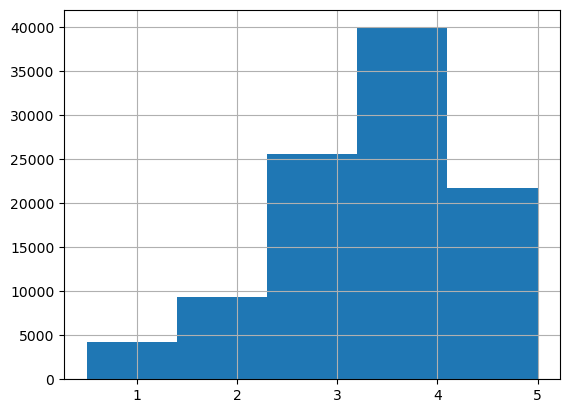

In [9]:
dataset['rating'].hist(bins=5)
plt.show()

In this dataset there are a lot of missing values, because not all the user/movie pairs have an associated rating. Indeed, each user rates only a few movies ! The goal of this notebook is to predict (some of) the missing user/movie ratings.

Print 
1. how many movies each of the 5 first users have rated, 
2. and print the percentage of available ratings in the whole dataset (i.e. the ratio between number of ratings and all the possible users/movies combinations):

In [10]:
#TOFILL
first5users= dataset.userId.unique()[0:5]
nbDistinctMovies= dataset.movieId.nunique()
# display(first5users, nbDistinctMovies)
# display(dataset[dataset.userId.isin(first5users)])

# 1.1- nb ranking pour les 5 premier users
ranking5=dataset[dataset.userId.isin(first5users)].groupby('userId').movieId.count()
print(f"How many movies each of the 5 first users have rated:\n {ranking5}")

# 1.2- nb ranking pour les 5 premier users
nb_ranking5=dataset[dataset.userId.isin(first5users)].loc[:,['userId', 'movieId']].count()
nb_ranking5=dataset[dataset.userId.isin(first5users)].loc[:,['userId']].count()
print(f"How many movies each of the 5 first users have rated:\n {nb_ranking5}")




How many movies each of the 5 first users have rated:
 userId
175      36
189      66
379    1218
483     275
486      56
Name: movieId, dtype: int64
How many movies each of the 5 first users have rated:
 userId    1651
dtype: int64


In [11]:
# 2. The percentage of available ratings in the whole dataset 
# (i.e. the ratio between number of ratings and all the possible users/movies combinations)

pct= dataset.shape[0]/(nb_movies*nb_users)
print(f"Percentage of available ratings in the whole dataset {pct*100 :.8f}")


Percentage of available ratings in the whole dataset 1.69996831


In [12]:

dataset[dataset.userId.isin(first5users)].groupby('userId').count()
# dataset[dataset.userId.isin(first5users)].rating.notna

dataset[dataset.userId.isin(first5users)].groupby('userId').agg(nulls=('rating', lambda x: x.isna().count()), non_nulls=('rating', lambda x: x.notna().count()))


,nulls,non_nulls
userId,,
175,36,36
189,66,66
379,1218,1218
483,275,275
486,56,56


### Display userId / movieId rating pivot matrice

There is only 1.7% of ratings that are available, which is normal as each hasn't rated all the movies. To see the dataset in a matrix form with all the missing ratings, use the `Dataframe.pivot()` function, with the `userId` as index, the `movieId` as columns, and the ratings for the `values` :

In [13]:
#TOFILL
pivotDatased=dataset.pivot(index='userId', columns='movieId', values='rating')
pivotDatased


movieId,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
userId,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Rating user1

Print all the ratings of user 1. To do so, use the *movies.csv* file and your `movie_ids_map` dictionnary to find the movie title from the new movie indexes, and print the real movie title associated to each rating of user 1 :

In [14]:
# the ratting of user 1
user1Ratings=dataset[dataset.userId.eq(1)]
display (user1Ratings.head(3))

,userId,movieId,rating,timestamp
243,1,7137,3.0,1445714974
257,1,8491,2.0,1445715276
254,1,8287,5.0,1445714966


In [15]:
def get_movies(data_path, movie_ids_map):
    """
    return a Panda DF with all movies defined in the dictionary
    """
    # read movies files [movieId,	title,	genres]
    movies= pd.read_csv(data_path, delimiter=',') # userId,movieId,rating,timestamp

    # only keep the movies that were already ranked
    movies= movies[movies['movieId'].isin(movie_ids_map.keys())]

    # update index of users with new movie id
    movies['movieId'] = movies['movieId'].map(movie_ids_map)
    
    # change indexs
    #movies.reset_index(names=['old_index'],inplace=True)
    #movies.set_index(keys=movies.movieId, inplace=True)
    
    display (movies.info())

    return movies

In [16]:
#TOFILL
movies_s_path =  ml_latest_small_path+'movies.csv'
movies= get_movies(movies_s_path, movie_ids_map)

<class 'pandas.core.frame.DataFrame'>
Index: 9724 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9724 non-null   int64 
 1   title    9724 non-null   object
 2   genres   9724 non-null   object
dtypes: int64(1), object(2)
memory usage: 303.9+ KB


None

In [17]:
# using join
display(user1Ratings.join(other=movies.set_index(keys=movies.movieId), 
                                           on=['movieId'], rsuffix = '_mov').head(3))


,userId,movieId,rating,timestamp,movieId_mov,title,genres
243,1,7137,3.0,1445714974,7137,Zombieland (2009),Action|Comedy|Horror
257,1,8491,2.0,1445715276,8491,The Drop (2014),Crime|Drama|Thriller
254,1,8287,5.0,1445714966,8287,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama


In [18]:
# using merge
display(user1Ratings.merge(right=movies, left_on='movieId', right_on='movieId').head(3))

,userId,movieId,rating,timestamp,title,genres
0,1,7137,3.0,1445714974,Zombieland (2009),Action|Comedy|Horror
1,1,8491,2.0,1445715276,The Drop (2014),Crime|Drama|Thriller
2,1,8287,5.0,1445714966,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama


In [19]:
# the ratting with titles of user 1
user1RatingsWithTitles=(user1Ratings.join(other=movies.set_index(keys=movies.movieId), on=['movieId'], rsuffix = '_mov'))
                        #.loc[:,['userId', 'movieId', 'rating', 'title', 'genres']])
display(user1RatingsWithTitles.info())
display(user1RatingsWithTitles.describe())
user1RatingsWithTitles
display(user1RatingsWithTitles.sort_values(by=['movieId']).reset_index())#, axes=0, ascending=True)

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 243 to 252
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       29 non-null     int64  
 1   movieId      29 non-null     int64  
 2   rating       29 non-null     float64
 3   timestamp    29 non-null     int64  
 4   movieId_mov  29 non-null     int64  
 5   title        29 non-null     object 
 6   genres       29 non-null     object 
dtypes: float64(1), int64(4), object(2)
memory usage: 1.8+ KB


None

,userId,movieId,rating,timestamp,movieId_mov
count,29.0,29.000000,29.000000,2.900000e+01,29.000000
mean,1.0,6540.517241,3.948276,1.445715e+09,6540.517241
std,0.0,2429.218946,0.805615,1.501627e+02,2429.218946
min,1.0,277.000000,2.000000,1.445715e+09,277.000000
25%,1.0,6298.000000,3.500000,1.445715e+09,6298.000000
50%,1.0,7355.000000,4.000000,1.445715e+09,7355.000000
75%,1.0,8045.000000,4.500000,1.445715e+09,8045.000000
max,1.0,8810.000000,5.000000,1.445715e+09,8810.000000


,index,userId,movieId,rating,timestamp,movieId_mov,title,genres
0,232,1,277,3.0,1445714835,277,"Shawshank Redemption, The (1994)",Crime|Drama
1,233,1,291,4.0,1445715029,291,Tommy Boy (1995),Comedy
2,234,1,1283,4.5,1445715228,1283,Good Will Hunting (1997),Drama|Romance
3,235,1,2670,4.0,1445714885,2670,Gladiator (2000),Action|Adventure|Drama
4,236,1,4607,4.0,1445714952,4607,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
5,237,1,5294,3.5,1445714960,5294,Collateral (2004),Action|Crime|Drama|Thriller
6,238,1,6236,4.0,1445715013,6236,Talladega Nights: The Ballad of Ricky Bobby (2...,Action|Comedy
7,239,1,6298,4.0,1445715064,6298,"Departed, The (2006)",Crime|Drama|Thriller
8,240,1,6693,4.5,1445715141,6693,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
9,241,1,6784,5.0,1445714980,6784,Step Brothers (2008),Comedy


## Matrix Factorization with Keras

Keras is a python library made for easily designing complex models such as deep learning models, in this module we are going to use just a few features from it to implement our simple matrix factorization model, as it makes a good introduction to the library before the next module about deep learning where you will also be using Keras.

The following function `get_mf_model` implements the model described in equation (2) in Koren's paper (without the $+\lambda(\ldots)$ part for the moment). So it basically tries to find the $p_u \in \mathbb{R}^k$ and $q_i \in \mathbb{R}^k$ vectors that minimizes the squared loss between their dot product $p_u^Tq_i$, and the observed ratings $r_{ui}$, from random initialization of $p_u$ and $q_i$. In machine learning terms, $p_u$ and $q_i$ are called the *embeddings* of the user $u$ and of the movie $i$ respectively. Their size $k$ is an hyper-parameter of the model, which is called the *rank* of the factorization.

To do so, it uses the functional API from Keras (the other API proposed is the sequential one, but is not adapted for this model), you can read about it here : https://keras.io/guides/functional_api/ .

Keras, unlike Numpy, uses a different progamming paradigm. Numpy uses an *imperative* programming style (like python in general), meaning that when you execute `x.dot(y)`, the dot product is actually calculated. Keras however, uses a *declarative* (also called *symbolic*) programming style, meaning that when you write `Dot()([x, y])`, you tell Keras than when you will call the *fit* function of your model in the future, you will want to do a dot product between the future values that *x* and *y* will have. And this is what Keras is about, it allows you to build your own model as a sequence of operations, describing each input and output, and then later fit it and predict with it.

Let's not get in too many details, but retain that the `get_mf_model` function below is not actually executing the model, it creates it, and returns an object of the class `keras.models.Model` that has been instructed with your model operations, and this object can then be trained with the classic `fit` and `predict` functions. 

Read carefully the comments in the code of the function to understand the different steps in the model creation process:

My note:

A BASIC MATRIX FACTORIZATION MODEL

- Matrix factorization models map both users and items to a joint latent factor space of dimensionality $f$
 such that user-item interactions are modeled as inner products in that space.
-  Accordingly, each item $i$ is associated with a vector $q_i ∈ \mathbb{R} ^f$,
 and each user $u$ is associated with a vector $p_u \in \mathbb{R} ^f$. 
For a given item $i$, the elements of $q_i$ measure the extent to which the item possesses those factors, positive or negative.

- For a given user $u$, the elements of $p_u$ measure the extent of interest the user has in items that are high
on the corresponding factors, again, positive or negative. 
The resulting dot product, $q_i^T p_u$, captures the interaction between user $u$ and item $i$—the user’s overall interest in the item’s characteristics.
This approximates user $u$’s rating of item $i$, which is denoted by $r_{ui}$, leading to the estimate
$$\widehat{r} _{ui} = q_i^T p_u \quad\text{(1)}$$

- The major challenge is computing the mapping of each item and user to factor vectors
$q_i$, $p_u \in  \mathbb{R} ^f$. 
After the recommender system completes this mapping, it can easily estimate the rating a user will give to any item
by using Equation 1. 

- Such a model is closely related to *singular value decomposition* (SVD), a well-established technique for identifying latent semantic factors in information retrieval. Applying SVD in the collaborative filtering domain requires factoring the user-item rating matrix



-  To learn the factor vectors 
$(p_u  \text{ and }  q_i  )$
, the system
minimizes the lambda_ularized squared error on the set of
known ratings
 $$ \to {min}_{q*, p*} \sum_{(u,i)∈κ} (r_{ui} - \mathrm{q}_{i}^{T}p_{u})^{2}  + λ(\left\| q_i \right\|^{2} + \left\| p_u \right\|^2)\quad\text{(2)}$$

 - Here, $κ$ is the set of the $(u,i)$ pairs for which $r_{ui}$ is known (the training set). 


 - -> use of https://latexeditor.lagrida.com/

In [20]:
from keras.models import Model
from keras.layers import Embedding, Input, Reshape
from keras.layers import Dot

def get_mf_model(nb_users, nb_movies, k):
    """
    Build a simple matrix factorization model from
    the number of user, the number of movies, and the size of the embeddings k.
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization
        
    """
    dim_embedddings = k
    
    #Inputs:
    #First we describe the input of the model, that is the training data that we will give it as X
    #In our case, the input are just the user index u and the movie index i.
    #So we declare two inputs of size one:
    u = Input(shape=(1,), dtype='int32', name = "u__user_id")
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    
    #Then let's declare our variable, the embeddings p and q.
    #First with the users, we declare that we have nb_users embeddings, each of size dim_embeddings.
    #An embedding object is indexed by calling it with the index parameter like a function,
    #so we add a `(u)` at the end to tell keras we want it to be indexed 
    #by the user ids we will pass at training time as inputs.
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding")(u)
    
    #Unfortunatly, when indexing an embeddings it keeps [1,k] matrix shape instead
    #of just a [k] vector, so we have to tell Keras that we just want a vector by
    #redefining its shape:
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Same thing for the movie embeddings:
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    #Then the dot product between the two indexed embeddings, 
    #we'll understand the axes = 1 part later.
    r_hat = Dot(axes = 1)([q_i, p_u])

    #We define our model by giving its input and outputs, in our case
    #the user and movie ids will be the inputs, and the output will be
    #the estimated rating r_hat, that is the dot product of the 
    #corresponding embeddings.
    model = Model(inputs=[u, i], outputs=r_hat)
    
    #Finally, we define the loss and metric to use, in our case the mean squared error,
    #along with the optimization method, we'll understand what is 'adam' later also.
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    return model



In [21]:
k = 30
mf_model = get_mf_model(nb_users, nb_movies, k)

Keras allows us to have a textual overview of the model we defined with the *summary()* function:

In [22]:
mf_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ i__movie_id         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u__user_id          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 1, 30)     │    291,720 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embedding │ (None, 1, 30)     │     18,300 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 30)        │          0 │ q_i__movie_embed… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embeddin… │ (None, 30)        │          0 │ p_u__user_embedd… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ q_i__movie_embed… │
│                     │                   │            │ p_u__user_embedd… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 310,020 (1.18 MB)

 Trainable params: 310,020 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

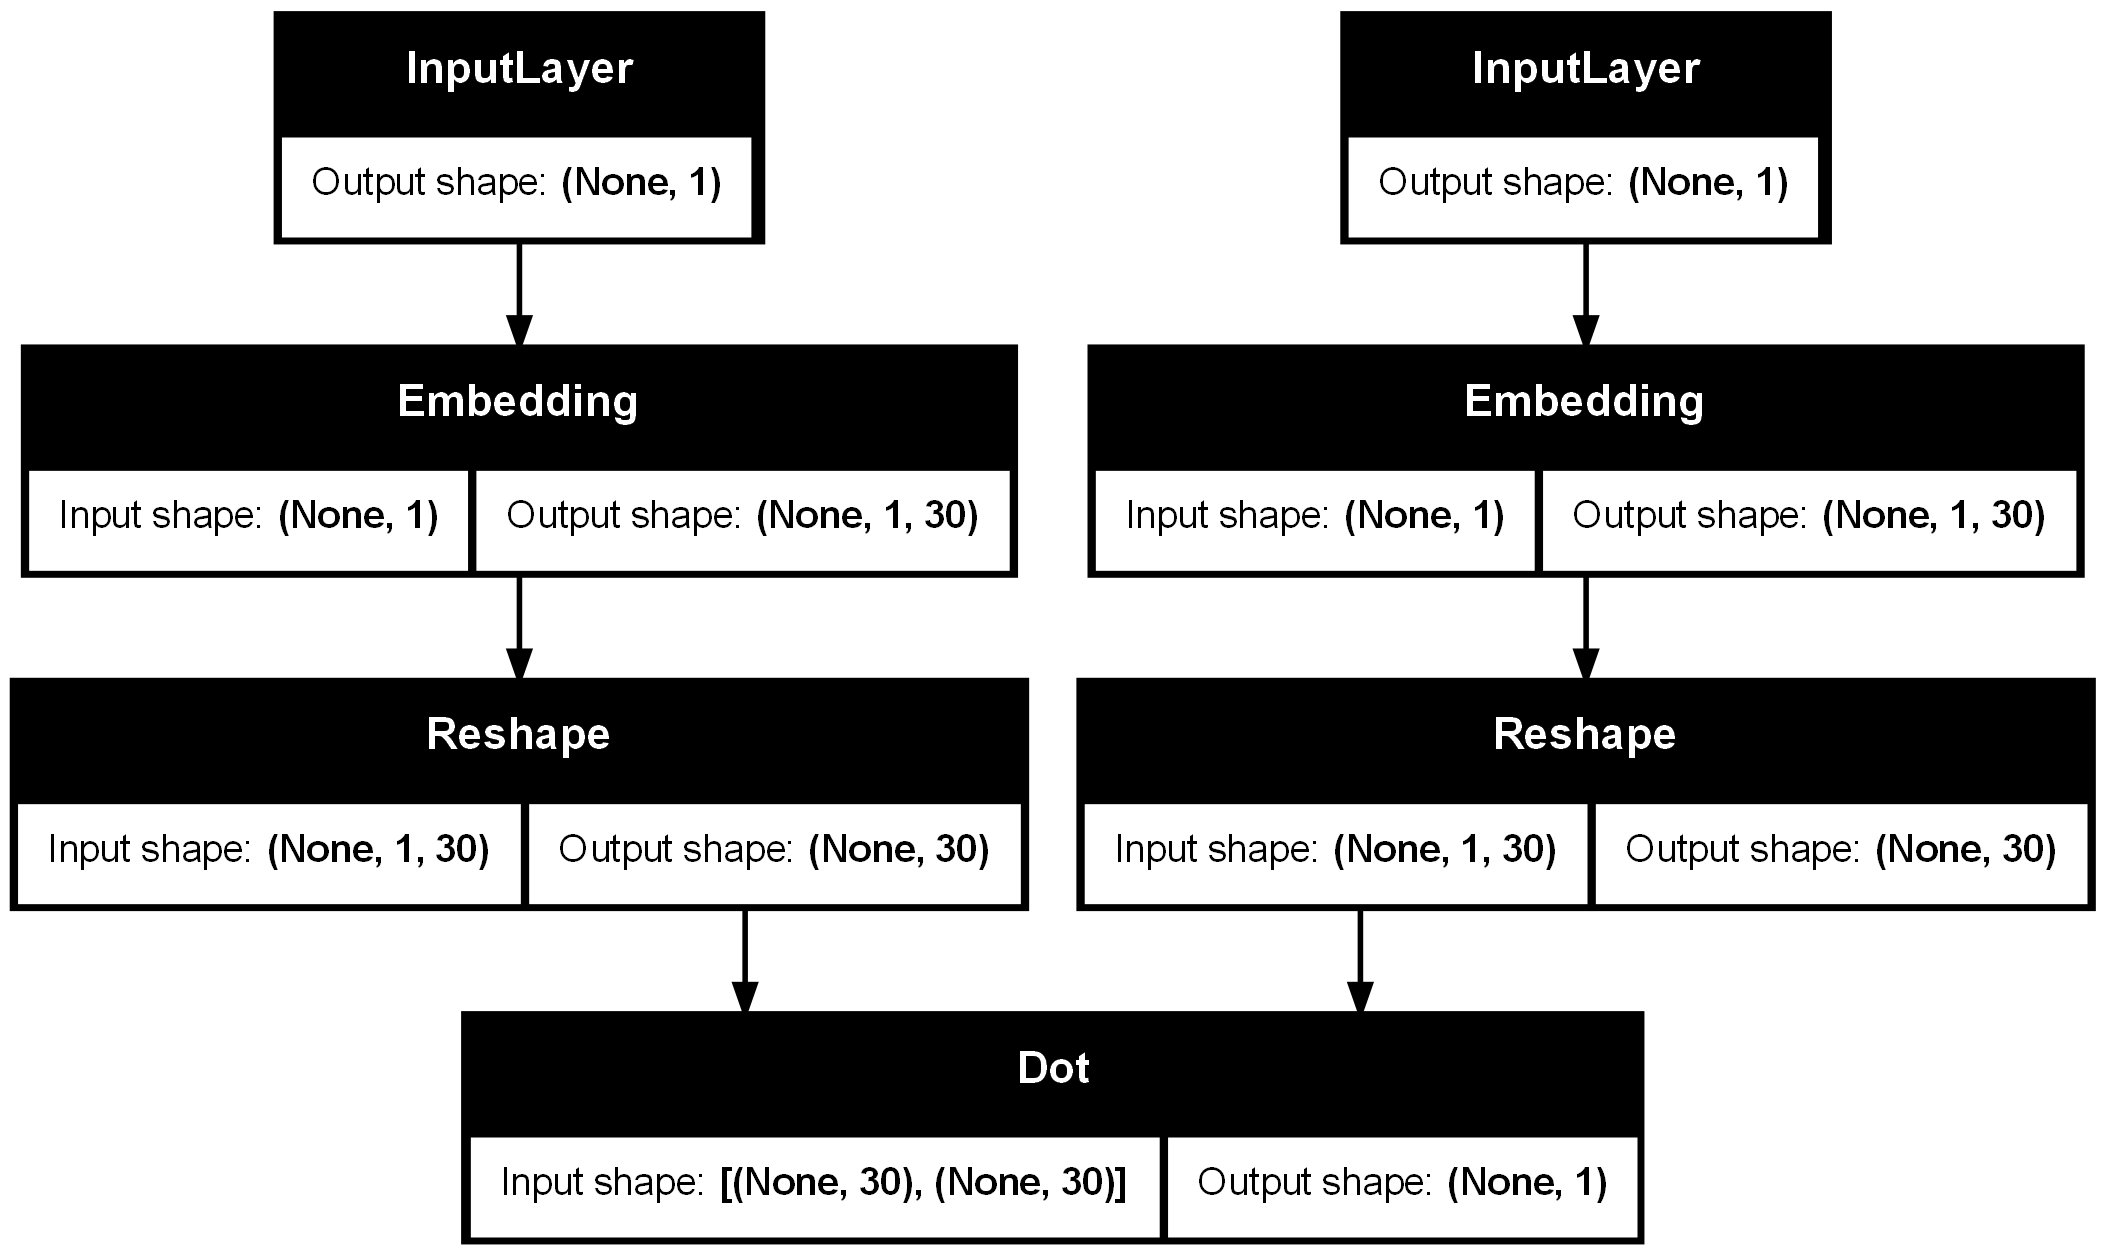

In [23]:
keras.utils.plot_model(mf_model, "my_first_model_with_shape_info.png", show_shapes=True)

Each of the keras objects we defined in our model is called a *layer*, and we find them in order in the first column. The *Param #* column gives the number of trainable parameters of the layer, in our case these are just the embeddings, and they should be equal to $nb\_users \times k$ and $nb\_movies \times k$. The *Connected to* column tells for each layer which layers are inputs for this layer (you can safely ignore the `[0][0]` for this module).

Finally the *Output Shape* column gives us the shape of the layer, each layer being a *tensor*. A tensor is the generalization of matrices to more than two dimensions. So a matrix is a 2D-tensor and a vector is a 1D-tensor, and each layer can be a matrix, a vector, or a higher-order tensor. The output shape we see is indeed the expected one at each layer, except there is this `None` in first dimension, why is that ?

To understand it, we have to get into how Keras is actually minimizing the mean squared loss of our model. In general, when in comes to minimizing error functions on big datasets, a generic method is to use Stocastic Gradient Descent (SGD), briefly described in page 4 of Koren's article. 

Read about gradient descent, SGD and its variant mini-batch SGD in Chapter 4 of *Hands on ML ...* (pages 111-120):
https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing

- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (V2) p 118 <148>


This is what Keras does when it fits the model, it initializes the $q_i$ and $p_u$ embedding vectors randomly, and then perform mini-batch SGD to find the minimum mean squared error on the training set. Since mini-batching means considering multiple training samples at the same time, Keras keeps the first dimension of each layer to stack the samples of each batch, this is why `None` is written, the actual batch_size being set at training time when calling the `fit` function. This is also why we had to set `axes=1` when calling the `Dot` layer in the `get_mf_model` function, because the first dimension (axe 0) of each layer is kept for the batches. And about the `optimizer='adam'`, it is just a variation of mini-batch SGD that is faster, we'll get into more details about SGD variations in the optional parts of this notebook.

Let's finally train our matrix factorization model on our movieLens data. The `epochs` parameter controls the number of iterations of the SGD algorithm, that is the number of times it is going to pass on each training rating and update the embeddings accordingly. Let's keep it at 20 for the moment:

In [24]:
history = mf_model.fit(X_train, y_train, epochs=20, batch_size=512)

Epoch 1/20


c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 13.3386 - mse: 13.3386
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 12.1829 - mse: 12.1829
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.1910 - mse: 5.1910
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.5253 - mse: 2.5253
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7239 - mse: 1.7239
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3326 - mse: 1.3326
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1212 - mse: 1.1212
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9632 - mse: 0.9632
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8720 - mse: 0.8720
Epoch 10/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7962 - mse: 0.7962
Epoch 11/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7480 - mse: 0.7480
Epoch 12/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6995 - mse: 0.6995
Epoch 13/20
178/178 ━━━━━━━━━━━

In [25]:
mf_model.save(model_path + "mf_model.keras")
#mf_model=keras.models.load_model(model_path + "mf_model.keras")

And we can now try to predict the test ratings, and report our root mean squared error like in other regression problems:

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = mf_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
 Test RMSE : 1.0737200895147418 


You should get about 1.1/1.2 RMSE, we can probably do better !

## Adding user and movie bias

Let's enhance our matrix factorization model and add the user and movie biases to the rating estimation function as in equation (4) of Koren's paper ; except we will for the moment forget about the global bias $\mu$ as it is not so intuitive to implement in Keras. Fill the function below to do so:

My notes:
- https://medium.com/@yashsonar213/how-to-build-a-recommendation-systems-matrix-factorization-using-keras-778931cc666f
- user & movie biais is
$$ b_{ui}= \mu + b_u +b_i$$

- rating with biais:
$$ \widehat{r} =\mu + b_u + b_i + q_i^Tp_u $$

- with chatGPT:
with this keras model defined in get_mf_bias_model function I want to add the u and i biais.
Can you help me?



In [27]:
from keras.layers import Add

def get_mf_bias_model(nb_users, nb_movies, k):
    """
    Build a smatrix factorization model with user and movie biases
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization with biases
        
    """
    
    dim_embedddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding")(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product of user and item embeddings
    d = Dot(axes=1, name='dot_user_item')([p_u, q_i])

    #TOFILL
    # User and item bias embeddings (1-dimensional)
    b_u = Embedding(nb_users, 1, name='b_u__user_bias')(u)
    b_u = Reshape((1,), name='b_u__user_bias_reshaped')(b_u)
    
    b_i = Embedding(nb_movies, 1, name='b_i__item_bias')(i)
    b_i = Reshape((1,), name='b_i__item_bias_reshaped')(b_i)

    # Final prediction: dot + user bias + item bias
    r_hat = Add(name='r_hat')([d, b_u, b_i])
    # Build and compile the model
    model = Model(inputs=[u, i], outputs=r_hat)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model

In [28]:
mf_bias_model = get_mf_bias_model(nb_users, nb_movies, k)

In [29]:
mf_bias_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ u__user_id          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ i__movie_id         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embedding │ (None, 1, 30)     │     18,300 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 1, 30)     │    291,720 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embeddin… │ (None, 30)        │          0 │ p_u__user_embedd… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 30)        │          0 │ q_i__movie_embed… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_bias      │ (None, 1, 1)      │        610 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__item_bias      │ (None, 1, 1)      │      9,724 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_user_item (Dot) │ (None, 1)         │          0 │ p_u__user_embedd… │
│                     │                   │            │ q_i__movie_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_bias_res… │ (None, 1)         │          0 │ b_u__user_bias[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__item_bias_res… │ (None, 1)         │          0 │ b_i__item_bias[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ r_hat (Add)         │ (None, 1)         │          0 │ dot_user_item[0]… │
│                     │                   │            │ b_u__user_bias_r… │
│                     │                   │            │ b_i__item_bias_r… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 320,354 (1.22 MB)

 Trainable params: 320,354 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = mf_bias_model.fit(X_train, y_train, epochs=20, batch_size=512)


Epoch 1/20


c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 12.7470 - mse: 12.7470
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.8182 - mse: 9.8182
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.0061 - mse: 4.0061
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.9978 - mse: 1.9978
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3722 - mse: 1.3722
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0849 - mse: 1.0849
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9193 - mse: 0.9193
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8120 - mse: 0.8120
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7352 - mse: 0.7352
Epoch 10/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6792 - mse: 0.6792
Epoch 11/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6280 - mse: 0.6280
Epoch 12/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6030 - mse: 0.6030
Epoch 13/20
178/178 ━━━━━━━━━━━━━

In [31]:
mf_bias_model.save(model_path + "mf_bias_model.keras")
#mf_bias_model=keras.models.load_model(model_path + "mf_bias_model.keras")

In [32]:
y_pred = mf_bias_model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print(" Test RMSE : %s " % test_rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 Test RMSE : 0.9789416903486807 


You should get a lower RMSE, about 1.0/1.1

## Adding L2 regularization

For the moment we have omitted the regularization of the embeddings and bias parameters, as described in equation (5) of Koren's paper. We are now going to add them to the model, have a look at https://keras.io/layers/embeddings/ and https://keras.io/regularizers/ to see how to do this with keras. Fill the function below to implement it:




- from le chat

To add L2 regularization to your model, you should apply it to the embedding layers (both the latent factors and the biases).

In Keras, this is done using kernel_regularizer=l2(λ) in the Embedding layers, where λ is your regularization strength (e.g. 1e-6 or 0.01).

In [129]:
from keras import regularizers
from keras.regularizers import l2

def get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_=1e-6):
    """
    Build a smatrix factorization model with user and movie biases, and L2 regularization
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization with biases
            and L2 regularization
        
    """
    
    
    #TOFILL
     # Inputs
    u = Input(shape=(1,), dtype='int32', name='u__user_id')
    i = Input(shape=(1,), dtype='int32', name='i__movie_id')
    
    # Embeddings with L2 regularization
    p_u = Embedding(nb_users, k, name='p_u__user_embedding',
                    embeddings_regularizer=l2(lambda_))(u)
    p_u = Reshape((k,), name='p_u__user_embedding_reshaped')(p_u)

    q_i = Embedding(nb_movies, k, name='q_i__movie_embedding',
                    embeddings_regularizer=l2(lambda_))(i)
    q_i = Reshape((k,), name='q_i__movie_embedding_reshaped')(q_i)

    # Bias embeddings with L2 regularization
    b_u = Embedding(nb_users, 1, name='b_u__user_bias',
                    embeddings_regularizer=l2(lambda_))(u)
    b_u = Reshape((1,), name='b_u__user_bias_reshaped')(b_u)

    b_i = Embedding(nb_movies, 1, name='b_i__movie_bias',
                    embeddings_regularizer=l2(lambda_))(i)
    b_i = Reshape((1,), name='b_i__movie_bias_reshaped')(b_i)
    
    # Dot product
    d = Dot(axes=1, name='dot_user_movie')([p_u, q_i])
    
    # Final prediction
    r_hat = Add(name='r_hat')([d, b_u, b_i])
    
    # Model
    model = Model(inputs=[u, i], outputs=r_hat)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
   

    return model



In [130]:
lambda_ = 0.00001
mf_bias_l2_reg_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)

In [131]:
mf_bias_l2_reg_model.save(model_path + "mf_bias_l2_reg_model.keras")
#mf_bias_l2_reg_model=keras.models.load_model(model_path + "mf_bias_l2_reg_model.keras")

In [132]:
mf_bias_l2_reg_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ u__user_id          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ i__movie_id         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embedding │ (None, 1, 30)     │     18,300 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 1, 30)     │    291,720 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embeddin… │ (None, 30)        │          0 │ p_u__user_embedd… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 30)        │          0 │ q_i__movie_embed… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_bias      │ (None, 1, 1)      │        610 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__movie_bias     │ (None, 1, 1)      │      9,724 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_user_movie      │ (None, 1)         │          0 │ p_u__user_embedd… │
│ (Dot)               │                   │            │ q_i__movie_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_bias_res… │ (None, 1)         │          0 │ b_u__user_bias[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__movie_bias_re… │ (None, 1)         │          0 │ b_i__movie_bias[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ r_hat (Add)         │ (None, 1)         │          0 │ dot_user_movie[0… │
│                     │                   │            │ b_u__user_bias_r… │
│                     │                   │            │ b_i__movie_bias_… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 320,354 (1.22 MB)

 Trainable params: 320,354 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
history = mf_bias_l2_reg_model.fit(X_train, y_train, epochs=20, batch_size=512)


Epoch 1/20


c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 13.0078 - mse: 13.0059
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.8992 - mse: 10.8949
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2707 - mse: 5.2456
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3348 - mse: 2.2833
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6048 - mse: 1.5364
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2727 - mse: 1.1921
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0971 - mse: 1.0069
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9909 - mse: 0.8929
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9136 - mse: 0.8090
Epoch 10/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8517 - mse: 0.7418
Epoch 11/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8162 - mse: 0.7017
Epoch 12/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7894 - mse: 0.6711
Epoch 13/20
178/178 ━━━━━━━━━━━━

In [134]:
mf_bias_l2_reg_model.save(model_path + "mf_bias_l2_reg_model.keras")
#mf_bias_l2_reg_model=keras.models.load_model(model_path + "mf_bias_l2_reg_model.keras")

In [135]:
y_pred = mf_bias_l2_reg_model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print(" Test RMSE : %s " % test_rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
 Test RMSE : 1.016625545980937 


You might get a slightly worse (higher) RMSE, because adding regularization makes the optimization process more complex, and it probably requires more than 20 epochs to properly converge. But in the end its gonna yield better results with more iterations, so let's change this.

## Early Stopping

Instead of setting manually the maximum number of epochs, we prefer to use *early stopping*. When training with early stopping, keras keeps a given validation set though the parameter `validation_split`, on which it is going to monitor a performance measure you give it (here the `mse`) at every epoch, and continue optimization while the mse on the validation set keeps going down, and stops it when it goes back up. This mechanism is an easy way to avoid over-fitting, you can read more about it there : https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In general when using early stopping we setup a high number of maximum epochs, that is never reach because the optimization is stopped by early stopping first :

In [136]:
from keras.callbacks import EarlyStopping

mf_bias_l2_reg_es_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)

early_stopping = EarlyStopping(monitor='val_mse', patience=5, verbose=1, restore_best_weights=True)

## TODO ask  mode min / max
# early_stopping = EarlyStopping(monitor='val_mse', mode='min', patience=5, verbose=1, restore_best_weights=True)
# early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
history = mf_bias_l2_reg_es_model.fit(X_train, y_train, epochs=500, batch_size=512, validation_split=0.1, 
                                callbacks=[early_stopping])

Epoch 1/500


c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 13.0697 - mse: 13.0678 - val_loss: 11.9471 - val_mse: 11.9453
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.3356 - mse: 11.3325 - val_loss: 7.8878 - val_mse: 7.8749
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3304 - mse: 6.3109 - val_loss: 3.3173 - val_mse: 3.2771
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6901 - mse: 2.6444 - val_loss: 2.1782 - val_mse: 2.1186
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.7655 - mse: 1.7023 - val_loss: 1.7648 - val_mse: 1.6921
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3907 - mse: 1.3153 - val_loss: 1.5544 - val_mse: 1.4716
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1904 - mse: 1.1054 - val_loss: 1.4341 - val_mse: 1.3431
Epoch 8/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0695 - mse: 0.9767 - val_loss: 1.3598 - val_mse: 1.2619
Epoch 9/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [137]:
mf_bias_l2_reg_es_model.save(model_path + "mf_bias_l2_reg_es_model.keras")
#mf_bias_l2_reg_es_model=keras.models.load_model(model_path + "mf_bias_l2_reg_es_model.keras")

As you can see the training stops before 500 epochs, when the validation MSE stops decreasing during 5 consecutive epochs (the patience value = 5). 

In [138]:
y_pred = mf_bias_l2_reg_es_model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print(" Test RMSE : %s " % test_rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
 Test RMSE : 1.0266084556574169 


## Grid search embedding size and regularization factor with early stopping

So for the moment we didn't grid search our model hyper-parameters, such as `k` and `lambda_`. There exists some scikit-learn wrappers for keras models in order to use scikit grid search functions, unfortunately they only work with single input keras models, which is not our case as we have two inputs: the user and the movie indexes.

So let's implement your own grid search function for the two parameters `k` and `lambda_`. With big enough datasets, it is not necessary to do a cross-validation for each hyper-parameter combination, and we can simply split the training set into a sub-training set and a validation set to test our hyper-parameters. It does work because the validation set is big enough to see enough data variations, and with very big datasets, it is anyway not possible anymore to do a full cross-validation as it takes too much time to train. 

Fill in the `grid_search` function below and use early stopping with a validation split (just like above), and retrieve the validation RMSE (you can get the MSE from the `history` variable that is returned by the `fit` method (and then take the `sqrt` of that)) for all the hyper-parameter combinations from the `param_grid` dictionary of hyper-parameter values. Call the `get_model_function` parameter (yes, you can pass functions as parameters!) to generate each model, and return the hyper-parameters that give the lowest RMSE on the 10% validation set, the RMSE value, and the best corresponding trained model.

In [139]:
def get_train_test_data(data, train_prop = 0.9):
    """
    Build train and test sets and reindex userIds and MovieIds from 0 with contiguous indexes.
    
    Input: 
        data : panda data frame
        train_prop : float : The proportion of the training set 
    
    Output:
        train : pandas.DataFrame : A dataframe with columns [userId, movieId, rating, timestamp], where
            the userId and movieId value have been replaced with new ids starting at 0. 
            Contains `train_prop` random entries from the input file.
        test : pandas.DataFrame : Same as `train`, contains the 1 - `train_prop` remaining entries.
        nb_users : int : Number of unique user ids
        nb_movies : int : Number of unique movie ids
        user_ids_map : dict : A mapping of original file userId to a new index starting at 0.
            Keys are int from the original userId column, values are int of the new indexation.
        movie_ids_map : dict : Same as `user_ids_map` for the movieIds.
    """
    
    #TOFILL


    # get nb users / movies
    nb_users=  data.userId.nunique() # len(user_ids_map)
    nb_movies= len(movie_ids_map)      # ratings.movieId.nunique()

    train= data.sample(frac=train_prop, axis=0)
    test=  data.drop(train.index)

    return train, test, nb_users, nb_movies

In [165]:
import itertools


def grid_search(data, param_grid, get_model_function, nb_users, nb_movies, validation_size = 0.1):
    """
    Performs a grid search over the 
    
    Input:
        data : DataFrame : The training set to be split between training and validation sets
        param_grid : dict : Dictionary containing the values of the hyper-parameters to grid-search
        get_model_function : function : A function that returns the keras model to grid-search
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        validation_size : float : Proportion of the validation set
        
    Output:
        best_params : dict : A dictionary of the best hyper-parameters values
        best_score : float : The validation RMSE corresponding to the best
        best_model : keras.Model : The model trained with the best hyper-parameters
        
    """
    
    best_score = np.inf
    best_params = {}
    best_model = None
    #TOFILL
    
    early_stopping = EarlyStopping(monitor='val_mse', patience=7, verbose=1, restore_best_weights=True)
    
    # General settings
    base_settings = {'epochs':500, 'batch_size':512, 'validation_split':0.1, 'callbacks':[early_stopping]}

    # get train / test from data dataset
    train, test, nb_users, nb_movies = get_train_test_data(data, train_prop = 1-validation_size)

    X_train = [train["userId"].to_numpy(), train["movieId"].to_numpy()]
    y_train = train["rating"].to_numpy()
    
    X_test = [test["userId"].to_numpy(), test["movieId"].to_numpy()]
    y_test = test["rating"].to_numpy()

    data_settiings = {'x':X_train, 'y':y_train}

    #print (*param_grid.values())
    for values in itertools.product(*param_grid.values()):
        variable_settings = dict(zip(param_grid.keys(), values))
        settings = {**data_settiings, **base_settings}

        model = get_model_function(nb_users, nb_movies, **variable_settings)
        #model(inputs=settings)
        
       # model = get_model_function(inputs=settings)  #get_model_function(nb_users, nb_movies, k, lambda_)
        model.fit(**settings)
        
        y_pred = model.predict(X_test)
        test_rmse = sqrt(mean_squared_error(y_test, y_pred))
        print(f"{variable_settings} Test RMSE : {test_rmse} ")
        if test_rmse < best_score:
            best_score=test_rmse
            best_params=variable_settings
            best_model=model

    return best_params, best_score, best_model

In [166]:
lambdas_ = [0.0002, 0.00005, 0.00002]
ks = [15,30]

param_grid = { 'k' : ks, 'lambda_' : lambdas_ }
best_params, best_score, best_model = grid_search(train, param_grid, get_mf_bias_l2_reg_model,
                                      nb_users, nb_movies, validation_size = 0.1)

Epoch 1/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 13.0392 - mse: 13.0263 - val_loss: 12.2526 - val_mse: 12.2442
Epoch 2/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.8766 - mse: 11.8594 - val_loss: 10.0928 - val_mse: 10.0052
Epoch 3/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.0407 - mse: 8.8989 - val_loss: 6.5052 - val_mse: 6.1673
Epoch 4/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6167 - mse: 5.2064 - val_loss: 4.3790 - val_mse: 3.7636
Epoch 5/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8411 - mse: 3.1700 - val_loss: 3.6135 - val_mse: 2.7981
Epoch 6/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2232 - mse: 2.3717 - val_loss: 3.2977 - val_mse: 2.3521
Epoch 7/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9276 - mse: 1.9577 - val_loss: 3.1282 - val_mse: 2.0917
Epoch 8/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7580 - mse: 1.7034 - val_loss: 3.0243 - val_mse: 1.9215
Epoch 9/500
144/144 ━━━━━━━━━━━━━━━━━━━

c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 13.0604 - mse: 13.0566 - val_loss: 12.2201 - val_mse: 12.2167
Epoch 2/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.7502 - mse: 11.7440 - val_loss: 9.8866 - val_mse: 9.8602
Epoch 3/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8125 - mse: 8.7715 - val_loss: 6.1050 - val_mse: 6.0113
Epoch 4/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1641 - mse: 5.0505 - val_loss: 3.7102 - val_mse: 3.5381
Epoch 5/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1351 - mse: 2.9461 - val_loss: 2.7682 - val_mse: 2.5340
Epoch 6/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3330 - mse: 2.0867 - val_loss: 2.3550 - val_mse: 2.0759
Epoch 7/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9592 - mse: 1.6708 - val_loss: 2.1246 - val_mse: 1.8109
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 1.
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
{'k': 15, 'lambda_': 5e-05} Test RMSE : 3.506308

c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 13.0426 - mse: 13.0409 - val_loss: 12.2451 - val_mse: 12.2436
Epoch 2/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.8402 - mse: 11.8378 - val_loss: 10.1889 - val_mse: 10.1798
Epoch 3/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.1231 - mse: 9.1086 - val_loss: 6.3433 - val_mse: 6.3078
Epoch 4/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3205 - mse: 5.2766 - val_loss: 3.6752 - val_mse: 3.6064
Epoch 5/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0488 - mse: 2.9727 - val_loss: 2.6113 - val_mse: 2.5154
Epoch 6/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1557 - mse: 2.0544 - val_loss: 2.1579 - val_mse: 2.0423
Epoch 7/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7411 - mse: 1.6214 - val_loss: 1.9059 - val_mse: 1.7747
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 1.
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
{'k': 15, 'lambda_': 2e-05} Test RMSE : 3.51025

c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 13.0851 - mse: 13.0605 - val_loss: 12.2165 - val_mse: 12.2018
Epoch 2/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.6499 - mse: 11.6184 - val_loss: 9.0973 - val_mse: 8.9358
Epoch 3/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.7168 - mse: 7.4622 - val_loss: 4.9282 - val_mse: 4.3657
Epoch 4/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2291 - mse: 3.5772 - val_loss: 3.6840 - val_mse: 2.8138
Epoch 5/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2592 - mse: 2.3397 - val_loss: 3.3194 - val_mse: 2.2776
Epoch 6/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9179 - mse: 1.8454 - val_loss: 3.1569 - val_mse: 2.0054
Epoch 7/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7775 - mse: 1.6054 - val_loss: 3.0665 - val_mse: 1.8413
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 1.
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
{'k': 30, 'lambda_': 0.0002} Test RMSE : 3.50298

c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 13.0635 - mse: 13.0561 - val_loss: 12.2339 - val_mse: 12.2283
Epoch 2/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.6868 - mse: 11.6769 - val_loss: 9.1241 - val_mse: 9.0811
Epoch 3/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6724 - mse: 7.6050 - val_loss: 4.4716 - val_mse: 4.3196
Epoch 4/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6143 - mse: 3.4352 - val_loss: 2.8340 - val_mse: 2.5857
Epoch 5/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3516 - mse: 2.0862 - val_loss: 2.3218 - val_mse: 2.0120
Epoch 6/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8968 - mse: 1.5749 - val_loss: 2.0813 - val_mse: 1.7265
Epoch 7/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6433 - mse: 1.2793 - val_loss: 1.9486 - val_mse: 1.5594
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 1.
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
{'k': 30, 'lambda_': 5e-05} Test RMSE : 3.507312

c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 13.0559 - mse: 13.0525 - val_loss: 12.2001 - val_mse: 12.1973
Epoch 2/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.6549 - mse: 11.6502 - val_loss: 9.1159 - val_mse: 9.0980
Epoch 3/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.5945 - mse: 7.5667 - val_loss: 4.3560 - val_mse: 4.2935
Epoch 4/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4827 - mse: 3.4088 - val_loss: 2.6352 - val_mse: 2.5321
Epoch 5/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1179 - mse: 2.0075 - val_loss: 2.0867 - val_mse: 1.9569
Epoch 6/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6187 - mse: 1.4835 - val_loss: 1.8231 - val_mse: 1.6732
Epoch 7/500
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3734 - mse: 1.2193 - val_loss: 1.6737 - val_mse: 1.5075
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 1.
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
{'k': 30, 'lambda_': 2e-05} Test RMSE : 3.502235

In [167]:
best_model.save(model_path + "best_model.keras")
#best_model=keras.models.load_model(model_path + "best_model.keras")

In [168]:
print('Best hyper-parameters : ' + str(best_params))
print('Best validation RMSE : ' + str(best_score))

Best hyper-parameters : {'k': 15, 'lambda_': 0.0002}
Best validation RMSE : 0.9468839934019433


In [169]:
y_pred = best_model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("Best model test RMSE : %s " % test_rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best model test RMSE : 0.9582877642853285 


## Retrain on all the dataset with the best hyper-parameters

Actually other hyper-parameters such as the ones of SGD should also be grid-searched, like the number of epochs or the batch size. But that would be a bit long for this course. 

Now we want to do the best prediction possible, so retrain below your model on the whole dataset, including the test set, with the best values obtained from your grid search to make new predictions with our optimal parameters :

In [145]:
from keras.callbacks import EarlyStopping

X = [dataset["userId"].to_numpy(), dataset["movieId"].to_numpy()]
y = dataset["rating"].to_numpy()

best_params={'k': 30, 'lambda_': 2e-05}#{'k': 30, 'lambda_': 5e-05}

#TOFILL
best_model2=get_mf_bias_l2_reg_model(nb_users, nb_movies, **best_params)# k =, lambda_ =)
early_stopping = EarlyStopping(monitor='val_mse', patience=10, verbose=1, restore_best_weights=True)
history=best_model2.fit(X, y, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500


c:\Users\HP\anaconda3\envs\ML4\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 13.0107 - mse: 13.0075 - val_loss: 11.7900 - val_mse: 11.7862
Epoch 2/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 10.8709 - mse: 10.8627 - val_loss: 6.6325 - val_mse: 6.5967
Epoch 3/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.1642 - mse: 5.1136 - val_loss: 2.9197 - val_mse: 2.8273
Epoch 4/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.3468 - mse: 2.2444 - val_loss: 2.0839 - val_mse: 1.9559
Epoch 5/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.6779 - mse: 1.5432 - val_loss: 1.7465 - val_mse: 1.5938
Epoch 6/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3707 - mse: 1.2130 - val_loss: 1.5728 - val_mse: 1.4013
Epoch 7/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2029 - mse: 1.0273 - val_loss: 1.4708 - val_mse: 1.2841
Epoch 8/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1057 - mse: 0.9158 - val_loss: 1.4081 - val_mse: 1.2092
Epoch 9/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10

In [146]:
best_model2.save(model_path + "best_model2.keras")
#best_model2=keras.models.load_model(model_path + "best_model2.keras")

In [147]:
y_pred = best_model2.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("Best model2 test RMSE : %s " % test_rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Best model2 test RMSE : 1.0070813614731093 


## Recommend the top-5 movies for the 10 first users

With your retrained best model with optimal hyper parameters, compute the predictions for all the ratings that are not in the `dataset` for the 10 first users (indexes from 0 to 9). That means all the movies $i$ that these users $u \in 0,\ldots,9$ haven't rated, thus all the $u,i$ combinations that are not in the `dataset` dataframe rows.

Order these predicted ratings for these users by decreasing order, and print out the 5 first ones, i.e. the ones that have the highest predicted ratings. Use the *movies.csv* file to print the real titles.

### Trick and Test place

In [148]:
# best_model2.summary()

In [149]:
user_id=0
X_gen=[np.full(len(movie_ids_map.values()),user_id),
        np.array(list(movie_ids_map.values()))]

y_gen =best_model2.predict(X_gen)


304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [150]:
# build result Data frame
df=pd.DataFrame()
df['userId']=np.full(len(movie_ids_map.values()),user_id)
df['movieId']= movie_ids_map.values()
df['rating']= y_gen.T[0]
#df['movieId']= np.array(list(movie_ids_map.values()))

(df[-df.movieId.isin(dataset[dataset.userId.eq(user_id)].movieId)]
 .merge(right=movies, left_on='movieId', right_on='movieId').sort_values(axis=0, by='rating', ascending=False)
 .head(5))#.iloc[:5])


,userId,movieId,rating,title,genres
809,0,877,5.751509,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
68,0,74,5.639508,Antonia's Line (Antonia) (1995),Comedy|Drama
9368,0,9600,5.632462,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
774,0,840,5.560674,"Streetcar Named Desire, A (1951)",Drama
4351,0,4583,5.544278,Come and See (Idi i smotri) (1985),Drama|War


In [151]:
df=pd.DataFrame([np.array(list(movie_ids_map.values())), y_gen.T[0]]).T
df.iloc[:5]

,0,1
0,0.0,4.670120
1,1.0,4.067186
2,2.0,3.901342
3,3.0,2.662210
4,4.0,3.483530


In [152]:
## using dataset 
display(dataset[dataset.userId.eq(user_id)]
.merge(right=movies, left_on='movieId', right_on='movieId')
.sort_values(axis=0, by='rating', ascending=False))

,userId,movieId,rating,timestamp,title,genres
0,0,1525,5.0,964982400,"Negotiator, The (1998)",Action|Crime|Drama|Mystery|Thriller
2,0,783,5.0,964982791,"Sword in the Stone, The (1963)",Animation|Children|Fantasy|Musical
3,0,2216,5.0,964982176,Goldfinger (1964),Action|Adventure|Thriller
20,0,830,5.0,964983484,Basic Instinct (1992),Crime|Mystery|Thriller
22,0,1223,5.0,964983504,"Game, The (1997)",Drama|Mystery|Thriller
...,...,...,...,...,...,...
26,0,1742,2.0,964983546,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller
48,0,919,2.0,964983393,Psycho (1960),Crime|Horror
6,0,1971,2.0,964982588,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller
152,0,1673,2.0,964981775,Toys (1992),Comedy|Fantasy


In [153]:
df=pd.DataFrame()
df['userId']=np.full(len(movie_ids_map.values()),user_id)
df['movieId']= movie_ids_map.values()
df['rating']= y_gen.T[0]
df

,userId,movieId,rating
0,0,0,4.670120
1,0,1,4.067186
2,0,2,3.901342
3,0,3,2.662210
4,0,4,3.483530
...,...,...,...
9719,0,9719,3.359044
9720,0,9720,2.984872
9721,0,9721,2.974028
9722,0,9722,2.960171


In [154]:
# df=pd.DataFrame()
# df['userId']=np.full(len(movie_ids_map.values()),user_id)
# df['movieId']= movie_ids_map.values()
# df['rating']= y_gen.T[0]
# df


### The 5 bests for one user

In [155]:
def get_top5_for_user(model, user_id, dataset):
    """
    Returns a list of the 5 movies that have the highest ratings among the unrated movies
    of user `user_id`, along with a list of their predicted ratings.
    
    Input :
        model : keras.models.Model : A trained matrix factorization model
        user_id : int : The user id to use
        dataset : DataFrame : The whole dataset, useful to find the movies 
            the user `user_id` has already rated
    
    Output :
        five_best_movie_ids : list : The five movie ids among unrated movies by user `user_id` 
            that have the highest predicted ratings, in order
        five_best_ratings : list : The corresponding five ratings
    """
    
    #TOFILL
    # X_gen is build with:
    # 1- nb_movies line field with userID
    # 2- all the movie ID in the ranking DB
    X_gen=[np.full(len(movie_ids_map.values()), user_id),
            np.array(list(movie_ids_map.values()))]
    
    # predict ranking for the user
    y_gen =model.predict(X_gen)

    # build the data frame of the predict result
    df=pd.DataFrame()
    df['userId']=np.full(len(movie_ids_map.values()),user_id)
    df['movieId']= movie_ids_map.values()
    df['rating']= y_gen.T[0]
    
    #df['movieId']= np.array(list(movie_ids_map.values()))

    # only keep (not rated movies) & sort by rating
    bestMovies=(df[-df.movieId.isin(dataset[dataset.userId.eq(user_id)].movieId)]
     .merge(right=movies, left_on='movieId', right_on='movieId')
     .sort_values(axis=0, by='rating', ascending=False))
     #.head(5))
     #.iloc[:5])
    # display (bestMovies.head(5))
    five_best_movie_ids = bestMovies['movieId'].head(5).reset_index(drop=True)
    five_best_ratings = bestMovies['rating'].head(5).reset_index(drop=True)
    
    return five_best_movie_ids, five_best_ratings

In [156]:
#TOFILL

five_best_movie_ids, five_best_ratings=get_top5_for_user(model=best_model2, user_id=0, dataset=dataset)
display(five_best_movie_ids, five_best_ratings)


304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


0     877
1      74
2    9600
3     840
4    4583
Name: movieId, dtype: int64

0    5.751509
1    5.639508
2    5.632462
3    5.560674
4    5.544278
Name: rating, dtype: float32

### The 5 bests for 10 first users

In [157]:
# look for the 5 best movies recomendation for the fist 10 
df5best=pd.DataFrame()
for user in list(user_ids_map.values())[0:10]:
    print (f"look for user {user}")
    five_best_movie_ids, five_best_ratings=get_top5_for_user(model=best_model2, user_id=user, dataset=dataset)
    df5best[f"best_movie{user}"]=five_best_movie_ids
    df5best[f"bestrating{user}"]=five_best_ratings

display (df5best)
    

look for user 0
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
look for user 1
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
look for user 2
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
look for user 3
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
look for user 4
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
look for user 5
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
look for user 6
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
look for user 7
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
look for user 8
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
look for user 9
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,best_movie0,bestrating0,best_movie1,bestrating1,best_movie2,bestrating2,best_movie3,bestrating3,best_movie4,bestrating4,best_movie5,bestrating5,best_movie6,bestrating6,best_movie7,bestrating7,best_movie8,bestrating8,best_movie9,bestrating9
0,877,5.751509,4583,4.438985,691,3.147387,659,4.552035,510,4.217656,242,4.573099,97,4.725082,2370,3.957283,277,4.716512,2916,4.209363
1,74,5.639508,840,4.418943,4596,3.127533,8943,4.528658,314,4.104715,592,4.485933,277,4.601012,52,3.931586,224,4.620203,4583,4.150997
2,9600,5.632462,877,4.389283,909,3.094633,5567,4.437819,840,4.007877,52,4.461564,461,4.554227,840,3.900550,897,4.602325,5938,4.105299
3,840,5.560674,2661,4.380201,522,3.081780,8557,4.424604,242,4.003665,633,4.436905,398,4.457421,242,3.868645,659,4.590971,8283,4.051363
4,4583,5.544278,9600,4.375133,5324,3.035388,2451,4.397782,36,3.999789,793,4.359118,899,4.431829,36,3.864642,257,4.523261,8486,4.042182


In [158]:
df5best

,best_movie0,bestrating0,best_movie1,bestrating1,best_movie2,bestrating2,best_movie3,bestrating3,best_movie4,bestrating4,best_movie5,bestrating5,best_movie6,bestrating6,best_movie7,bestrating7,best_movie8,bestrating8,best_movie9,bestrating9
0,877,5.751509,4583,4.438985,691,3.147387,659,4.552035,510,4.217656,242,4.573099,97,4.725082,2370,3.957283,277,4.716512,2916,4.209363
1,74,5.639508,840,4.418943,4596,3.127533,8943,4.528658,314,4.104715,592,4.485933,277,4.601012,52,3.931586,224,4.620203,4583,4.150997
2,9600,5.632462,877,4.389283,909,3.094633,5567,4.437819,840,4.007877,52,4.461564,461,4.554227,840,3.900550,897,4.602325,5938,4.105299
3,840,5.560674,2661,4.380201,522,3.081780,8557,4.424604,242,4.003665,633,4.436905,398,4.457421,242,3.868645,659,4.590971,8283,4.051363
4,4583,5.544278,9600,4.375133,5324,3.035388,2451,4.397782,36,3.999789,793,4.359118,899,4.431829,36,3.864642,257,4.523261,8486,4.042182


## Visualize the embeddings

Let's now have a look at what is going on in the embedding space of the movies that we learnt. Our brain cannot picture anything beyond 3 dimensions, and we learnt high dimensional embeddings (k=15 or 30), so we are going to project the movies embeddings on a 2D plane, first with PCA, and then with another algorithm made for visualizing high dimensional spaces called t-sne.

### PCA

#### show datas / get_weights() vectors...

You have already studied PCA, it is a useful technique for dimensionality reduction, but also simply for visualization. Don't forget to scale your embeddings first. To access the embeddings values of your keras model, have a look at the *get_weights()* function.

Compute a PCA on all your movies embeddings, get the 2 first principal components, and do a scatter plot of all the movies on a 2D plane, where each movie is a point defined by the two values of the two first principal components of the PCA from its embedding. Add the titles of the movies to each point of the plot (use plotly to do so it will be clearer), and try to see if you can interpret the axes of the PCA through to different movie genres, like in Figure 3 from the article *Matrix Factorization Techniques for Recommender Systems*.

In [ ]:
for idx, weight in enumerate(best_model2.get_weights()):
    print(f"Layer {idx} Weights Shape: {weight.shape}")

# user_embedding=best_model2.get_weights()[0]
# movie_embedding=best_model2.get_weights()[1]


Layer 0 Weights Shape: (610, 30)
Layer 1 Weights Shape: (9724, 30)
Layer 2 Weights Shape: (610, 1)
Layer 3 Weights Shape: (9724, 1)


array([[ 0.7309666 , -0.44723278,  1.2199613 , ...,  0.49941418,
        -0.7169019 , -0.61517906],
       [ 0.56476384, -0.43787315,  0.54144835, ...,  0.46150723,
        -0.51026446, -0.4714927 ],
       [ 1.1585882 ,  0.28330523,  1.0805713 , ..., -0.31897756,
         0.1414974 , -0.33100873],
       ...,
       [ 0.6126581 , -0.4512593 ,  1.5080894 , ...,  0.68709844,
        -0.8350503 , -0.4556753 ],
       [ 0.12036916, -0.4220879 ,  0.04478317, ...,  0.37380674,
        -0.45347136, -0.44665045],
       [ 0.44271088, -0.16456582,  1.5428511 , ...,  0.50906897,
        -0.698848  , -0.6781319 ]], dtype=float32)

**My notes:**
- best_model2.summary() show Embedding layers that have a corresponding weight representation in best_model2.get_weights()

- main flow related

```
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embedding │ (None, 1, 30)     │     18,300 │ u__user_id[0][0]  │ --> Layer 0 Weights Shape: (610, 30)
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 1, 30)     │    291,720 │ i__movie_id[0][0] │ --> Layer 1 Weights Shape: (9724, 30)
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
```



- biais flow related



```
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_bias      │ (None, 1, 1)      │        610 │ u__user_id[0][0]  │ --> Layer 2 Weights Shape: (610, 1)
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__movie_bias     │ (None, 1, 1)      │      9,724 │ i__movie_id[0][0] │ --> Layer 3 Weights Shape: (9724, 1)
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
```

In [160]:
best_model2.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ u__user_id          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ i__movie_id         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embedding │ (None, 1, 30)     │     18,300 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 1, 30)     │    291,720 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embeddin… │ (None, 30)        │          0 │ p_u__user_embedd… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 30)        │          0 │ q_i__movie_embed… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_bias      │ (None, 1, 1)      │        610 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__movie_bias     │ (None, 1, 1)      │      9,724 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_user_movie      │ (None, 1)         │          0 │ p_u__user_embedd… │
│ (Dot)               │                   │            │ q_i__movie_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_bias_res… │ (None, 1)         │          0 │ b_u__user_bias[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__movie_bias_re… │ (None, 1)         │          0 │ b_i__movie_bias[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ r_hat (Add)         │ (None, 1)         │          0 │ dot_user_movie[0… │
│                     │                   │            │ b_u__user_bias_r… │
│                     │                   │            │ b_i__movie_bias_… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 961,064 (3.67 MB)

 Trainable params: 320,354 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 640,710 (2.44 MB)

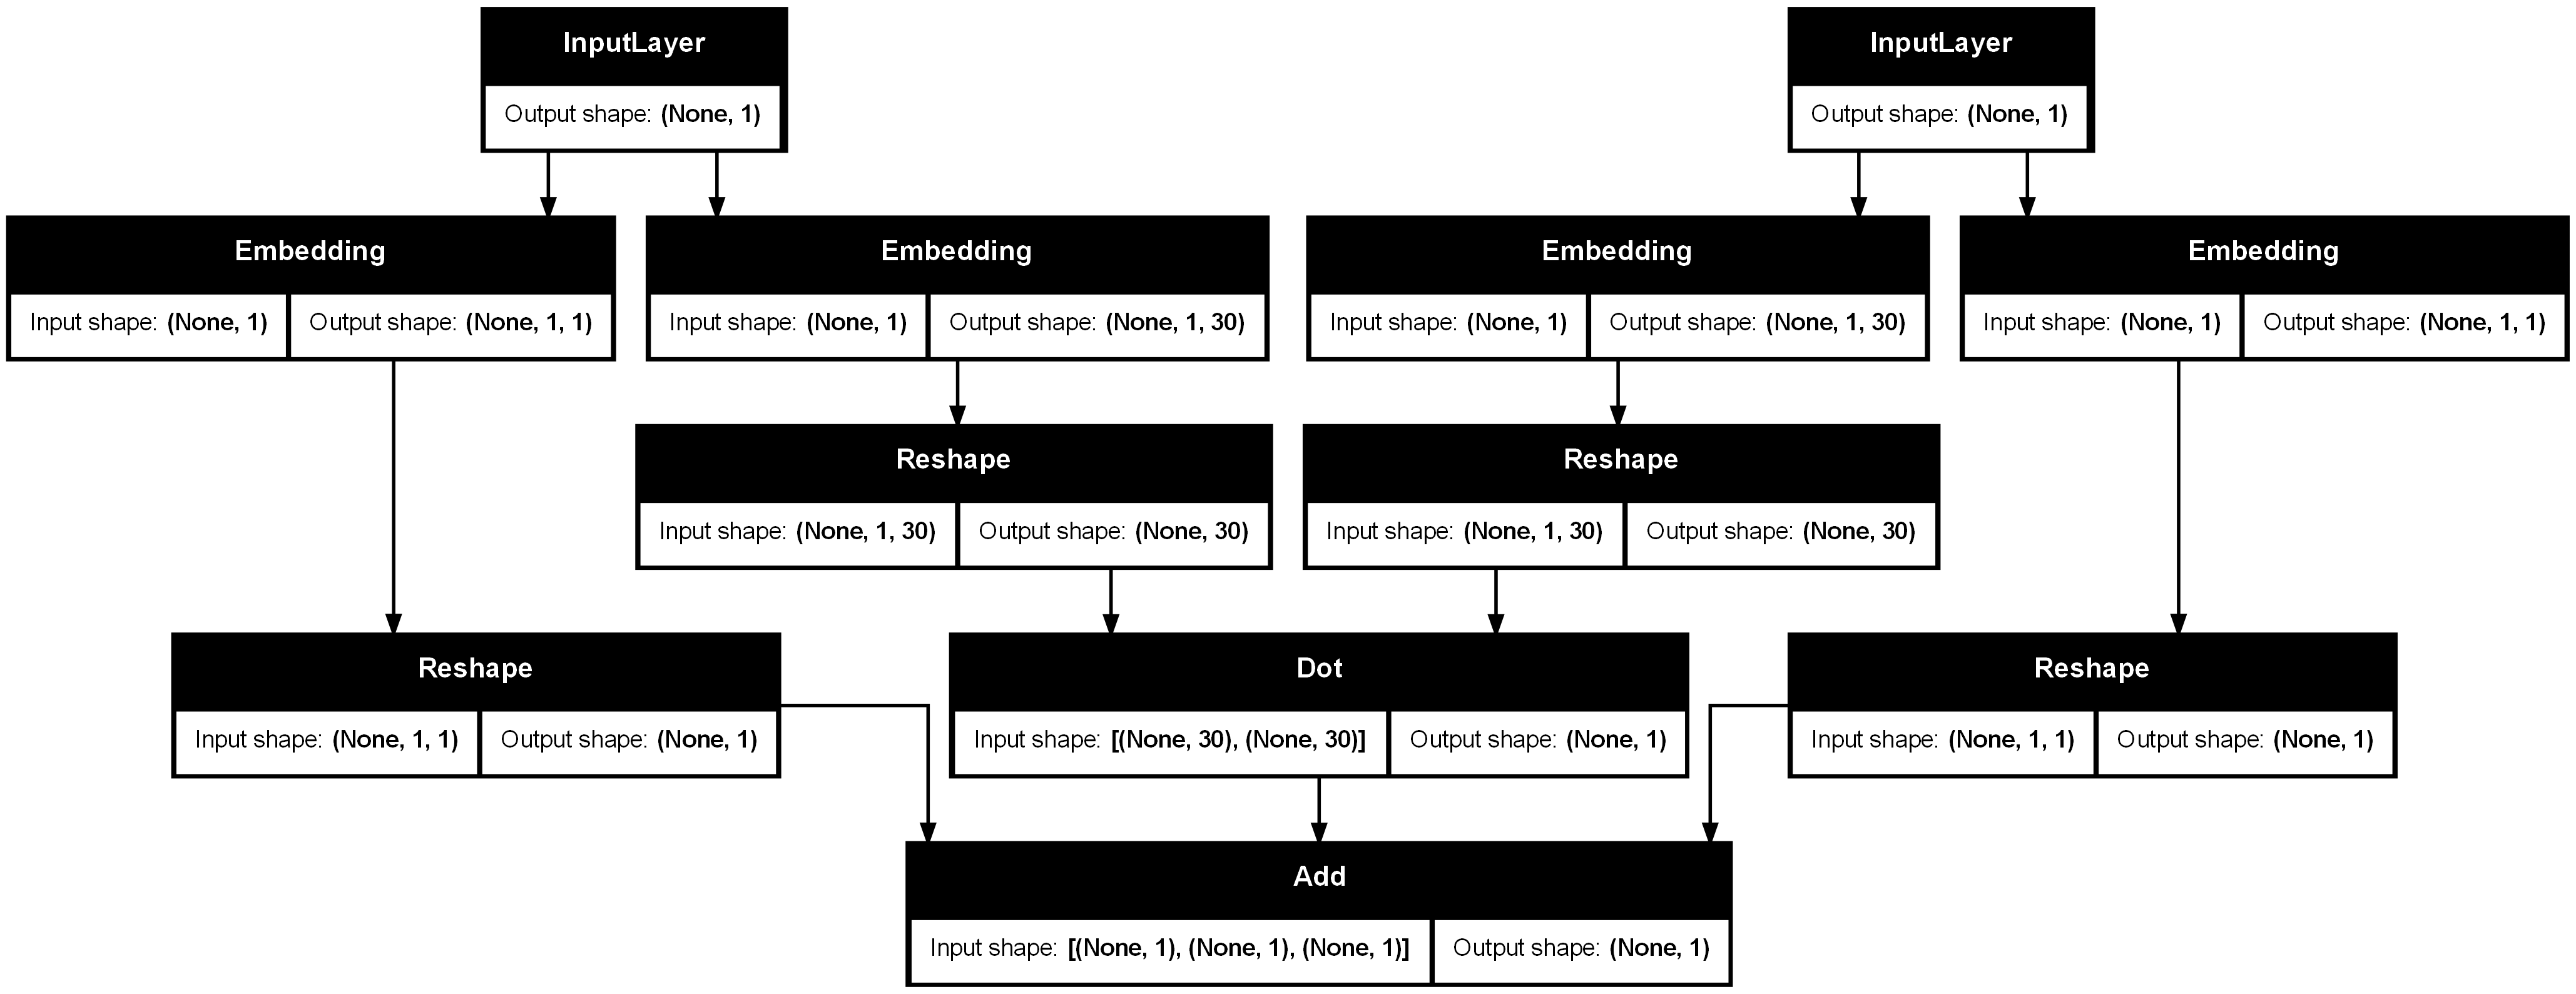

In [161]:
keras.utils.plot_model(best_model2, "best_model2.png", show_shapes=True)

### using seaborne

In [ ]:
best_model2.get_weights()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

user_embedding  = best_model2.get_weights()[0]
movie_embedding = best_model2.get_weights()[1]

ss_user_embedding  = StandardScaler().fit_transform(user_embedding )
ss_movie_embedding = StandardScaler().fit_transform(movie_embedding)

pca = PCA(n_components=2)
data_2D = pca.fit_transform(ss_movie_embedding)

data_2D


#TOFILL


array([[ 6.853986  , -1.2072275 ],
       [ 4.4063673 , -2.9205396 ],
       [ 4.14834   , -1.6122172 ],
       ...,
       [-0.41795978, -0.45277527],
       [-0.4673901 , -0.45285213],
       [ 3.3070953 ,  0.50188005]], dtype=float32)

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA


def plot_X(pca, X, labels, test=False, title=None):
    """ plot the data and the labels in a PCA 2D projection
    Input
    - X: numpy array[n_samples, m_features]
    - labels: numpy array(n_samples), cluster number
    - test: if test is false will run the PCA fit process
    - title: of the diagram
    Return
    - fig: the matplotlb figure
    """
    if test == False:
        data_2D = pca.fit_transform(X)
        print("pca fitted")
    else: 
        data_2D = pca.transform(X)

    axes, fig = plt.subplots(1, 1, figsize=(6, 4))
    fig = sns.scatterplot(x=data_2D[:, 0], y=data_2D[:, 1],
                        hue=labels)
  
    fig.set_title(title)
    return fig


In [203]:
movies.merge(right=dataset, left_on='movieId', right_on='movieId')

,movieId,title,genres,userId,rating,timestamp
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,67,2.5,1158531426
1,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,467,4.0,831400444
2,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,63,4.0,1161520134
3,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,144,5.0,832105242
4,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,489,3.5,1328229305
...,...,...,...,...,...,...
100831,9719,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,183,4.0,1537109082
100832,9720,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,183,3.5,1537109545
100833,9721,Flint (2017),Drama,183,3.5,1537109805
100834,9722,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,183,3.5,1537110021


In [216]:
# movies list with rounded mean rating
mymoviesinf=(movies.merge(right=dataset, left_on='movieId', right_on='movieId')
             .groupby(by=['movieId', 'title', 'genres'])
             .aggregate(r=pd.NamedAgg(column="rating", aggfunc="mean")))
mymoviesinf['rounded_rating']= mymoviesinf['r'].apply(lambda x: round(x,1))
mymoviesinf

,,,r,rounded_rating
movieId,title,genres,,
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,3.9
1,Jumanji (1995),Adventure|Children|Fantasy,3.431818,3.4
2,Grumpier Old Men (1995),Comedy|Romance,3.259615,3.3
3,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143,2.4
4,Father of the Bride Part II (1995),Comedy,3.071429,3.1
...,...,...,...,...
9719,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4.000000,4.0
9720,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.500000,3.5
9721,Flint (2017),Drama,3.500000,3.5


pca fitted


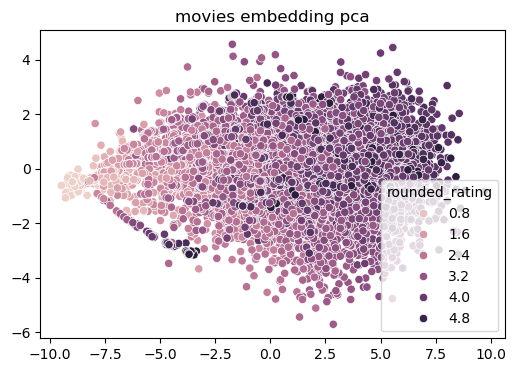

In [217]:
pca = PCA(n_components=2)

plot_X(pca=pca, X=ss_movie_embedding, labels=mymoviesinf.rounded_rating, title='movies embedding pca')
plt.show()

### t-sne

Let's do the same with t-sne, an algorithm specialized for visualizing high dimensional spaces, you can read more about it there : https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [221]:
from sklearn.manifold import TSNE

#TOFILL:
tsne_movie=TSNE(n_components=2).fit_transform(ss_movie_embedding)

axes, fig = plt.subplots(1, 1, figsize=(6, 4))
fig = sns.scatterplot(x=tsne_movie[:, 0], y=tsne_movie[:, 1], hue=mymoviesinf.rounded_rating)

fig.set_title('movie TSNE')




Text(0.5, 1.0, 'movie TSNE')

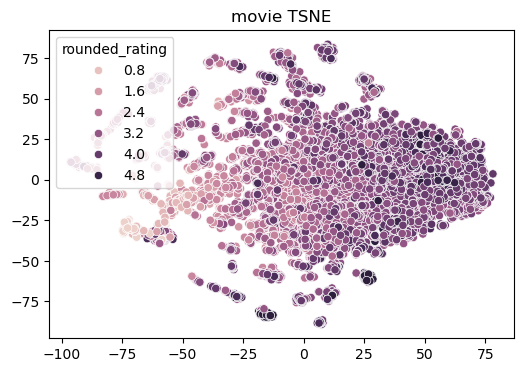

In [222]:
plt.show()

T-sne in general tends to preserve local similarities better than PCA. In any case, it's always interesting to try both for visualizing high dimensional data.

Optionally, you can export your embedding and upload them on https://projector.tensorflow.org/ to visualize the embeddings in 3D. You can also use the movies genres from the *movies.csv* file to make one plot for each movie genre and try to see if some parts of the embedding space are representative of a movie genre.

# GOING FURTHER

## Recommend movies to yourself

Implement a function that ask you to rate 20 movies, then add your own ratings to the dataset, retrain the model, and compute your own top-5 predictions.

In [ ]:
import random

def rate_my_movies(my_user_id, dataset, nb_movies, nb_to_rate, movie_ids_map):
    """
    Returns a dataframe in the same format as the dataset dataframe, with
    ratings entered by the user for `nb_to_rate` random movies
    
    Input :
        my_user_id : int : The user_id of the new ratings
        dataset : DataFrame : The whole dataset 
        nb_movies : int : Number of unique movie ids
        nb_to_rate : int : Number of movies to rate
        movie_ids_map : dict : The mapping of original file userId to a new index starting at 0.
    
    Output : 
        my_ratings : DataFrame : A dataframe with the same column as `dataset` containing
            the new ratings entered by the user
    """
    #TOFILL
 



    return my_ratings


my_user_id = len(user_ids_map)

my_ratings = rate_my_movies(my_user_id, dataset, nb_movies, 20, movie_ids_map)



In [ ]:
dataset_with_me = pd.concat([dataset, my_ratings], axis = 0).sample(frac=1).reset_index(drop=True)

X_with_me = [dataset_with_me["userId"].to_numpy(), dataset_with_me["movieId"].to_numpy()]
y_with_me = dataset_with_me["rating"].to_numpy()


In [ ]:
best_model=get_mf_bias_l2_reg_model(nb_users + 1, nb_movies, k = best_params['k'], lambda_ = best_params['lambda_'])

early_stopping = EarlyStopping(monitor='val_mse', patience=10, verbose=1, restore_best_weights=True)

best_model.fit(X_with_me, y_with_me, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

In [ ]:
five_best_movie_ids, five_best_ratings =  get_top5_for_user(best_model, my_user_id, dataset)

## Reuse the movie embeddings to predict the movies genre with multi-label classification

Beyond the goal of predicting missing rating, the matrix factorization techniques also produces vectorial representation of movies and users: their embeddings, what we just visualized for the movies. With a big enough dataset, these embeddings actually are good abstract representations of the movies and of the users, and can be reused as features for other tasks, such as classification.

In the *movies.csv*, there is a column that gives the genres of each movie. Let's try to predict the genres of the movies from the embeddings we learnt. As you can see, each movie can have more than one genre, so in classification terms, more than one class. We can achieve that with *multilabel classification*. You can read more about it there: https://scikit-learn.org/stable/modules/multiclass.html

Load the movies genre, encode them as binary classes and use the classes imported below to train a multilabel classifier that uses the movie embeddings as features, and the movie genres as classes. Use the *OneVsRestClassifier* with a simple *LinearSVC* without any hyper-parameter tuning. Finally print the test accuracy, F1, precision and recall for each class, as well as the number of time each class appears in the dataset.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#TOFILL


On rare classes, you should get a very high accuracy, with a very low F1. Indeed these classes are really imbalanced : there are a few positives, hence the classifier is largely biased toward the negatives, and rarely predict a positive for these classes. This is why accuracy is generally a bad measure with imbalanced dataset : the high number of true negatives makes the accuracy number high, while our model is actually barely capable of predicting true positives.

Let's compare our classifier performance with a *DummyClassifier*, the dummy classifier takes the ratio $r = \frac{nb\_positives}{nb\_positives + nb\_negatives}$ as the probability to predict a positive, and then do it randomly.

In [ ]:
from sklearn.dummy import DummyClassifier

#TOFILL



As you can see, simply respecting the class balance, even at random, produces better F1 on most classes. One way to compensate for class imbalance is to tell the classifier to weight more the true samples at training time, accordingly with the ratio $r$ between true and false samples. With scikit-learn SVM implementation, you can use the argument *class_weight* for setting the weight of the positive and negative samples at training time. See : https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

But if you just want to set the class weights accordingly with the ratio between positives and negatives, you can just set *class_weight = ‘balanced’*. Test it with the LinearSVC classifier:

In [ ]:
#TOFILL



F1 is now much better than with the dummy classifier, however is is still not very convincing. This is quite normal given the size of the dataset we are using, which is pretty small to get really meaningful embeddings. But with bigger datasets, reusing embeddings as features for auxiliary tasks such as classification is actually a very effective way of doing so when there is no other informations about the items we try to classify. Here the items are the movies, the dataset doesn't provide more information about them, but one could imagine fetching from internet textual descriptions of the movies and use them as features alongside the embeddings to improve the classification results.

## Try out the different SGD algorithms

In all the notebook we used the 'adam' `optimizer` to train our model, which is a variation of SGD. Keras proposes different variations of SGD: https://keras.io/optimizers/ . This article gif images gives an intuitive view of their different behavior : https://medium.com/@ramrajchandradevan/the-evolution-of-gradient-descend-optimization-algorithm-4106a6702d39

Try a few ones with our model and see how the training and testing loss evolves.

In [ ]:
#TOFILL

## Add the global bias $\mu$  parameter to the model

Remember we didn't added the global bias $\mu$ to our model yet (Equations (4-5) from Koren's paper). Use your best google skills to find a way to add an embedding layer that does that.

Hint : Use a constant `Input` layer.

In [ ]:
from keras import backend as K
#TOFILL


## Implement your own Stochastic Gradient Descent for Matrix Factorization with numpy instead of Keras (very optional)

Now you know everything to implement your own matrix factorization SGD model, all with numpy arrays. Start without the biases again, and without mini-batches. The gradient update equations are described in page 4 of Koren's paper. Let's initialize your $p$ and $q$ embeddings with a gaussian sampling. Print the RMSE at the beginning of each epoch, and finally compute the RMSE of your model on the test set.

In [ ]:
from numpy.random import normal

P = normal(size = (nb_users,k))
Q = normal(size = (nb_movies,k))

gamma = 0.1
lambda_ = 0.00001
epochs = 10

for e in range(epochs):
    for j in range(train.shape[0]):
        u = train['userId'].iloc[j]
        i = train['movieId'].iloc[j]
        r_ui = train['rating'].iloc[j]
        
        #TOFILL
